## **AutoEncoders**

In [5]:
# %% [markdown]
# # Autoencoder Implementation from Scratch using NumPy
# 
# This notebook implements a fully connected autoencoder with:
# - **Multiple hidden layers** in encoder and decoder
# - **Customizable bottleneck dimension**
# - **Multiple activation functions** (ReLU, Sigmoid, Tanh)
# - **Backpropagation from scratch**
# - **Mini-batch gradient descent**
# - **Learning rate scheduling**
# - **L2 regularization**


##  **Import Required Libraries**

In [16]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_breast_cancer
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

print("✓ Libraries imported successfully!")


✓ Libraries imported successfully!


## **Autoencoder Class**

In [ ]:
class Autoencoder:
    def __init__(self, input_dim, encoder_layers, bottleneck_dim, decoder_layers=None,
                 activation='relu', output_activation='sigmoid', learning_rate=0.01,
                 l2_lambda=0.0001, batch_size=32):
        self.input_dim = input_dim
        self.encoder_layers = encoder_layers
        self.bottleneck_dim = bottleneck_dim
        self.decoder_layers = decoder_layers if decoder_layers else encoder_layers[::-1]
        self.activation = activation
        self.output_activation = output_activation
        self.learning_rate = learning_rate
        self.initial_lr = learning_rate
        self.l2_lambda = l2_lambda
        self.batch_size = batch_size
        
        # Initialize weights and biases
        self.weights = {}
        self.biases = {}
        self._initialize_parameters()
        self.history = {
            'loss': [],
            'val_loss': []
        }
    
    def _initialize_parameters(self):
        """Initialize weights and biases using He initialization."""
        np.random.seed(42)
        
        # Build encoder 
        layer_dims = [self.input_dim] + self.encoder_layers + [self.bottleneck_dim]
        # Initialize  weights
        for i in range(len(layer_dims) - 1):
            self.weights[f'encoder_W{i+1}'] = np.random.randn(layer_dims[i], layer_dims[i+1]) * np.sqrt(2.0 / layer_dims[i])
            self.biases[f'encoder_b{i+1}'] = np.zeros((1, layer_dims[i+1]))
        # Build decoder 
        layer_dims = [self.bottleneck_dim] + self.decoder_layers + [self.input_dim]
        # Initialize  weights
        for i in range(len(layer_dims) - 1):
            self.weights[f'decoder_W{i+1}'] = np.random.randn(layer_dims[i], layer_dims[i+1]) * np.sqrt(2.0 / layer_dims[i])
            self.biases[f'decoder_b{i+1}'] = np.zeros((1, layer_dims[i+1]))
    
    def _activation_function(self, z, activation_type):
        if activation_type == 'relu':
            return np.maximum(0, z)
        elif activation_type == 'sigmoid':
            return 1 / (1 + np.exp(-np.clip(z, -500, 500)))
        elif activation_type == 'tanh':
            return np.tanh(z)
        elif activation_type == 'linear':
            return z
        else:
            raise ValueError(f"Unknown activation: {activation_type}")
    
    def _activation_derivative(self, z, activation_type):
        if activation_type == 'relu':
            return (z > 0).astype(float)
        elif activation_type == 'sigmoid':
            a = self._activation_function(z, 'sigmoid')
            return a * (1 - a)
        elif activation_type == 'tanh':
            return 1 - np.tanh(z) ** 2
        elif activation_type == 'linear':
            return np.ones_like(z)
        else:
            raise ValueError(f"Unknown activation: {activation_type}")
    
    def _forward_pass(self, X):
        cache = {'A0': X}
        A = X
        
        # Encoder forward pass
        num_encoder_layers = len(self.encoder_layers) + 1
        for i in range(1, num_encoder_layers + 1):
            Z = A @ self.weights[f'encoder_W{i}'] + self.biases[f'encoder_b{i}']
            A = self._activation_function(Z, self.activation)
            cache[f'encoder_Z{i}'] = Z
            cache[f'encoder_A{i}'] = A
        
        #  (latent representation)
        cache['bottleneck'] = A
        # Decoder forward pass
        num_decoder_layers = len(self.decoder_layers) + 1
        for i in range(1, num_decoder_layers):
            Z = A @ self.weights[f'decoder_W{i}'] + self.biases[f'decoder_b{i}']
            A = self._activation_function(Z, self.activation)
            cache[f'decoder_Z{i}'] = Z
            cache[f'decoder_A{i}'] = A
        # Output layer
        Z = A @ self.weights[f'decoder_W{num_decoder_layers}'] + self.biases[f'decoder_b{num_decoder_layers}']
        A = self._activation_function(Z, self.output_activation)
        cache[f'decoder_Z{num_decoder_layers}'] = Z
        cache['output'] = A
        
        return cache
    
    def _compute_loss(self, X, X_reconstructed):
        m = X.shape[0]
        # Mean squared error
        mse = np.mean((X - X_reconstructed) ** 2)
        # L2 regularization
        l2_reg = 0
        for key, weight in self.weights.items():
            l2_reg += np.sum(weight ** 2)
        l2_reg *= (self.l2_lambda / (2 * m))
        
        total_loss = mse + l2_reg
        return total_loss
    
    def _backward_pass(self, X, cache):

        

        # Get batch size
        m = X.shape[0]
        gradients = {}
        # Output layer gradient
        dA = (cache['output'] - X) / m
        # Decoder backward pass
        num_decoder_layers = len(self.decoder_layers) + 1
        for i in range(num_decoder_layers, 0, -1):
            if i == num_decoder_layers:
                dZ = dA * self._activation_derivative(cache[f'decoder_Z{i}'], self.output_activation)
            else:
                dZ = dA * self._activation_derivative(cache[f'decoder_Z{i}'], self.activation)
            
            A_prev = cache[f'decoder_A{i-1}'] if i > 1 else cache['bottleneck']
            
            gradients[f'decoder_dW{i}'] = A_prev.T @ dZ + (self.l2_lambda / m) * self.weights[f'decoder_W{i}']
            gradients[f'decoder_db{i}'] = np.sum(dZ, axis=0, keepdims=True)
            
            #  propagate gradient backward
            dA = dZ @ self.weights[f'decoder_W{i}'].T
        # Now dA has gradient w.r.t. bottleneck
        # Encoder backward pass
        num_encoder_layers = len(self.encoder_layers) + 1
        for i in range(num_encoder_layers, 0, -1):
            dZ = dA * self._activation_derivative(cache[f'encoder_Z{i}'], self.activation)
            
            A_prev = cache[f'encoder_A{i-1}'] if i > 1 else cache['A0']
            
            gradients[f'encoder_dW{i}'] = A_prev.T @ dZ + (self.l2_lambda / m) * self.weights[f'encoder_W{i}']
            gradients[f'encoder_db{i}'] = np.sum(dZ, axis=0, keepdims=True)
            
            # Always propagate gradient backward (even though we don't use it after the last layer)
            dA = dZ @ self.weights[f'encoder_W{i}'].T
        
        return gradients
    
    def _update_parameters(self, gradients):
        for key in self.weights.keys():
            grad_key = key.replace('_W', '_dW')
            self.weights[key] -= self.learning_rate * gradients[grad_key]
        
        for key in self.biases.keys():
            grad_key = key.replace('_b', '_db')
            self.biases[key] -= self.learning_rate * gradients[grad_key]
    
    def _learning_rate_schedule(self, epoch, schedule_type='step'):
        if schedule_type == 'step':
            # Reduce by factor of 0.5 every 50 epochs
            decay_rate = 0.5
            decay_steps = 50
            self.learning_rate = self.initial_lr * (decay_rate ** (epoch // decay_steps))
        elif schedule_type == 'exponential':
            # Exponential decay
            decay_rate = 0.95
            self.learning_rate = self.initial_lr * (decay_rate ** epoch)
    
    def fit(self, X_train, X_val=None, epochs=100, verbose=True, lr_schedule='step'):
        n_samples = X_train.shape[0]
        n_batches = n_samples // self.batch_size
        
        for epoch in range(epochs):
            # Shuffle data
            indices = np.random.permutation(n_samples)
            X_shuffled = X_train[indices]
            
            epoch_loss = 0
            
            # Mini-batch training
            for batch in range(n_batches):
                start_idx = batch * self.batch_size
                end_idx = start_idx + self.batch_size
                X_batch = X_shuffled[start_idx:end_idx]
                
                # Forward pass
                cache = self._forward_pass(X_batch)
                
                # Compute loss
                loss = self._compute_loss(X_batch, cache['output'])
                epoch_loss += loss
                
                # Backward pass
                gradients = self._backward_pass(X_batch, cache)
                
                # Update parameters
                self._update_parameters(gradients)
            
            # Average loss for epoch
            epoch_loss /= n_batches
            self.history['loss'].append(epoch_loss)
            
            # Validation loss
            if X_val is not None:
                cache_val = self._forward_pass(X_val)
                val_loss = self._compute_loss(X_val, cache_val['output'])
                self.history['val_loss'].append(val_loss)

            if lr_schedule:
                self._learning_rate_schedule(epoch, lr_schedule)

            if verbose and (epoch + 1) % 10 == 0:
                if X_val is not None:
                    print(f"Epoch {epoch+1}/{epochs} - Loss: {epoch_loss:.6f} - Val Loss: {val_loss:.6f} - LR: {self.learning_rate:.6f}")
                else:
                    print(f"Epoch {epoch+1}/{epochs} - Loss: {epoch_loss:.6f} - LR: {self.learning_rate:.6f}")
    
    def encode(self, X):
        cache = self._forward_pass(X)
        return cache['bottleneck']
    
    def decode(self, Z):
        A = Z
        num_decoder_layers = len(self.decoder_layers) + 1
        
        for i in range(1, num_decoder_layers):
            Z_dec = A @ self.weights[f'decoder_W{i}'] + self.biases[f'decoder_b{i}']
            A = self._activation_function(Z_dec, self.activation)
    
        # Output layer
        Z_dec = A @ self.weights[f'decoder_W{num_decoder_layers}'] + self.biases[f'decoder_b{num_decoder_layers}']
        A = self._activation_function(Z_dec, self.output_activation)
        
        return A
    
    def reconstruct(self, X):
        cache = self._forward_pass(X)
        return cache['output']
    
    def get_reconstruction_error(self, X):
        X_reconstructed = self.reconstruct(X)
        mse = np.mean((X - X_reconstructed) ** 2)
        return mse

print("✓ Autoencoder class defined successfully!")


✓ Autoencoder class defined successfully!


## **Load Dataset**

In [25]:
print("=" * 70)
print("LOADING BREAST CANCER DATASET")
print("=" * 70)

# Load data
data = load_breast_cancer()
X = data.data
y = data.target

print(f"\n✓ Dataset loaded successfully!")
print(f"  - Dataset shape: {X.shape}")
print(f"  - Input dimension: {X.shape[1]}")
print(f"  - Number of samples: {X.shape[0]}")
print(f"  - Malignant samples: {np.sum(y == 0)}")
print(f"  - Benign samples: {np.sum(y == 1)}")


LOADING BREAST CANCER DATASET

✓ Dataset loaded successfully!
  - Dataset shape: (569, 30)
  - Input dimension: 30
  - Number of samples: 569
  - Malignant samples: 212
  - Benign samples: 357


## **Data Preprocessing**

In [26]:

print("\n" + "=" * 70)
print("PREPROCESSING DATA")
print("=" * 70)

# Standardize
X_mean = np.mean(X, axis=0)
X_std = np.std(X, axis=0)
X_standardized = (X - X_mean) / X_std
# Normalize 
X_min = np.min(X_standardized, axis=0)
X_max = np.max(X_standardized, axis=0)
X_normalized = (X_standardized - X_min) / (X_max - X_min + 1e-8)

print(f"\n✓ Data preprocessed!")
print(f"  - Standardized (mean=0, std=1)")
print(f"  - Normalized to range [0, 1]")
print(f"  - Data range: [{X_normalized.min():.3f}, {X_normalized.max():.3f}]")



PREPROCESSING DATA

✓ Data preprocessed!
  - Standardized (mean=0, std=1)
  - Normalized to range [0, 1]
  - Data range: [0.000, 1.000]


## **Train-Validation Split**

In [27]:

train_size = int(0.8 * len(X_normalized))
X_train = X_normalized[:train_size]
X_val = X_normalized[train_size:]
y_train = y[:train_size]
y_val = y[train_size:]

print("\n" + "=" * 70)
print("DATA SPLIT")
print("=" * 70)
print(f"\n✓ Data split completed!")
print(f"  - Training samples: {X_train.shape[0]} ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"  - Validation samples: {X_val.shape[0]} ({X_val.shape[0]/len(X)*100:.1f}%)")



DATA SPLIT

✓ Data split completed!
  - Training samples: 455 (80.0%)
  - Validation samples: 114 (20.0%)


## **Create and Configure Autoencoder**

In [28]:
# **Architecture:**
# - Input: 30 features
# - Encoder: [20, 10] → Bottleneck: 3D
# - Decoder: [10, 20] → Output: 30 features
# 
# **Hyperparameters:**
# - Activation: ReLU
# - Output Activation: Sigmoid
# - Learning Rate: 0.01 (with step decay)
# - L2 Regularization: 0.0001
# - Batch Size: 32
# - Epochs: 100

# %%
print("\n" + "=" * 70)
print("AUTOENCODER CONFIGURATION")
print("=" * 70)

print("\n📐 Architecture:")
print(f"  Input Layer:       {X.shape[1]} features")
print(f"  Encoder Hidden:    [20, 10]")
print(f"  Bottleneck:        3 dimensions")
print(f"  Decoder Hidden:    [10, 20]")
print(f"  Output Layer:      {X.shape[1]} features")

print("\n⚙️  Hyperparameters:")
print(f"  Activation:        ReLU")
print(f"  Output Activation: Sigmoid")
print(f"  Learning Rate:     0.01 (step decay)")
print(f"  L2 Lambda:         0.0001")
print(f"  Batch Size:        32")
print(f"  Epochs:            100")

# Create autoencoder
autoencoder = Autoencoder(
    input_dim=X.shape[1],
    encoder_layers=[20, 10],
    bottleneck_dim=3,
    decoder_layers=[10, 20],
    activation='relu',
    output_activation='sigmoid',
    learning_rate=0.01,
    l2_lambda=0.0001,
    batch_size=32
)

print("\n✓ Autoencoder created successfully!")
print(f"  - Compression ratio: {X.shape[1]}/{autoencoder.bottleneck_dim} = {X.shape[1]/autoencoder.bottleneck_dim:.1f}x")



AUTOENCODER CONFIGURATION

📐 Architecture:
  Input Layer:       30 features
  Encoder Hidden:    [20, 10]
  Bottleneck:        3 dimensions
  Decoder Hidden:    [10, 20]
  Output Layer:      30 features

⚙️  Hyperparameters:
  Activation:        ReLU
  Output Activation: Sigmoid
  Learning Rate:     0.01 (step decay)
  L2 Lambda:         0.0001
  Batch Size:        32
  Epochs:            100

✓ Autoencoder created successfully!
  - Compression ratio: 30/3 = 10.0x


## **Train AutoEncoder**

In [29]:

# Training with mini-batch gradient descent and learning rate scheduling

print("\n" + "=" * 70)
print("TRAINING AUTOENCODER")
print("=" * 70)
print()


autoencoder.fit(X_train, X_val, epochs=100, verbose=True, lr_schedule='step')

print("\n" + "=" * 70)
print("✓ TRAINING COMPLETED!")
print("=" * 70)



TRAINING AUTOENCODER

Epoch 10/100 - Loss: 0.080456 - Val Loss: 0.083577 - LR: 0.010000
Epoch 20/100 - Loss: 0.063697 - Val Loss: 0.065360 - LR: 0.010000
Epoch 30/100 - Loss: 0.045543 - Val Loss: 0.045838 - LR: 0.010000
Epoch 40/100 - Loss: 0.030857 - Val Loss: 0.029814 - LR: 0.010000
Epoch 50/100 - Loss: 0.024408 - Val Loss: 0.022615 - LR: 0.010000
Epoch 60/100 - Loss: 0.022408 - Val Loss: 0.020670 - LR: 0.005000
Epoch 70/100 - Loss: 0.021108 - Val Loss: 0.019458 - LR: 0.005000
Epoch 80/100 - Loss: 0.019949 - Val Loss: 0.018475 - LR: 0.005000
Epoch 90/100 - Loss: 0.019235 - Val Loss: 0.017677 - LR: 0.005000
Epoch 100/100 - Loss: 0.018343 - Val Loss: 0.017013 - LR: 0.005000

✓ TRAINING COMPLETED!


## **Evaluate Performance**

In [30]:

# Calculate reconstruction errors and analyze the learned representations

print("\n" + "=" * 70)
print("EVALUATION RESULTS")
print("=" * 70)

# Reconstruction errors
train_error = autoencoder.get_reconstruction_error(X_train)
val_error = autoencoder.get_reconstruction_error(X_val)

print(f"\n📊 Reconstruction Error (MSE):")
print(f"  Training:   {train_error:.6f}")
print(f"  Validation: {val_error:.6f}")
print(f"  Difference: {abs(train_error - val_error):.6f}")

# Encode to 3D space
Z_train = autoencoder.encode(X_train)
Z_val = autoencoder.encode(X_val)

print(f"\n🔬 Latent Space Analysis:")
print(f"  Original dimensions:  {X.shape[1]}")
print(f"  Bottleneck dimension: {autoencoder.bottleneck_dim}")
print(f"  Compression ratio:    {X.shape[1]/autoencoder.bottleneck_dim:.1f}x")
print(f"  Encoded shape:        {Z_train.shape}")

# Statistics of latent dimensions
print(f"\n📈 Latent Dimension Statistics:")
for i in range(3):
    print(f"  Dimension {i+1}: mean={Z_train[:, i].mean():.3f}, std={Z_train[:, i].std():.3f}, "
          f"range=[{Z_train[:, i].min():.3f}, {Z_train[:, i].max():.3f}]")



EVALUATION RESULTS

📊 Reconstruction Error (MSE):
  Training:   0.018150
  Validation: 0.016933
  Difference: 0.001218

🔬 Latent Space Analysis:
  Original dimensions:  30
  Bottleneck dimension: 3
  Compression ratio:    10.0x
  Encoded shape:        (455, 3)

📈 Latent Dimension Statistics:
  Dimension 1: mean=0.681, std=0.323, range=[0.000, 1.485]
  Dimension 2: mean=0.008, std=0.022, range=[0.000, 0.174]
  Dimension 3: mean=0.173, std=0.101, range=[0.000, 0.536]


## **Visualizations**


GENERATING VISUALIZATIONS...


/tmp/ipykernel_93395/598492768.py:48: MatplotlibDeprecationWarning: You have mixed positional and keyword arguments, some input may be discarded.  This is deprecated since 3.9 and will become an error in 3.11.
  ax4.legend(*scatter.legend_elements(), title="Classes", labels=['Malignant', 'Benign'])


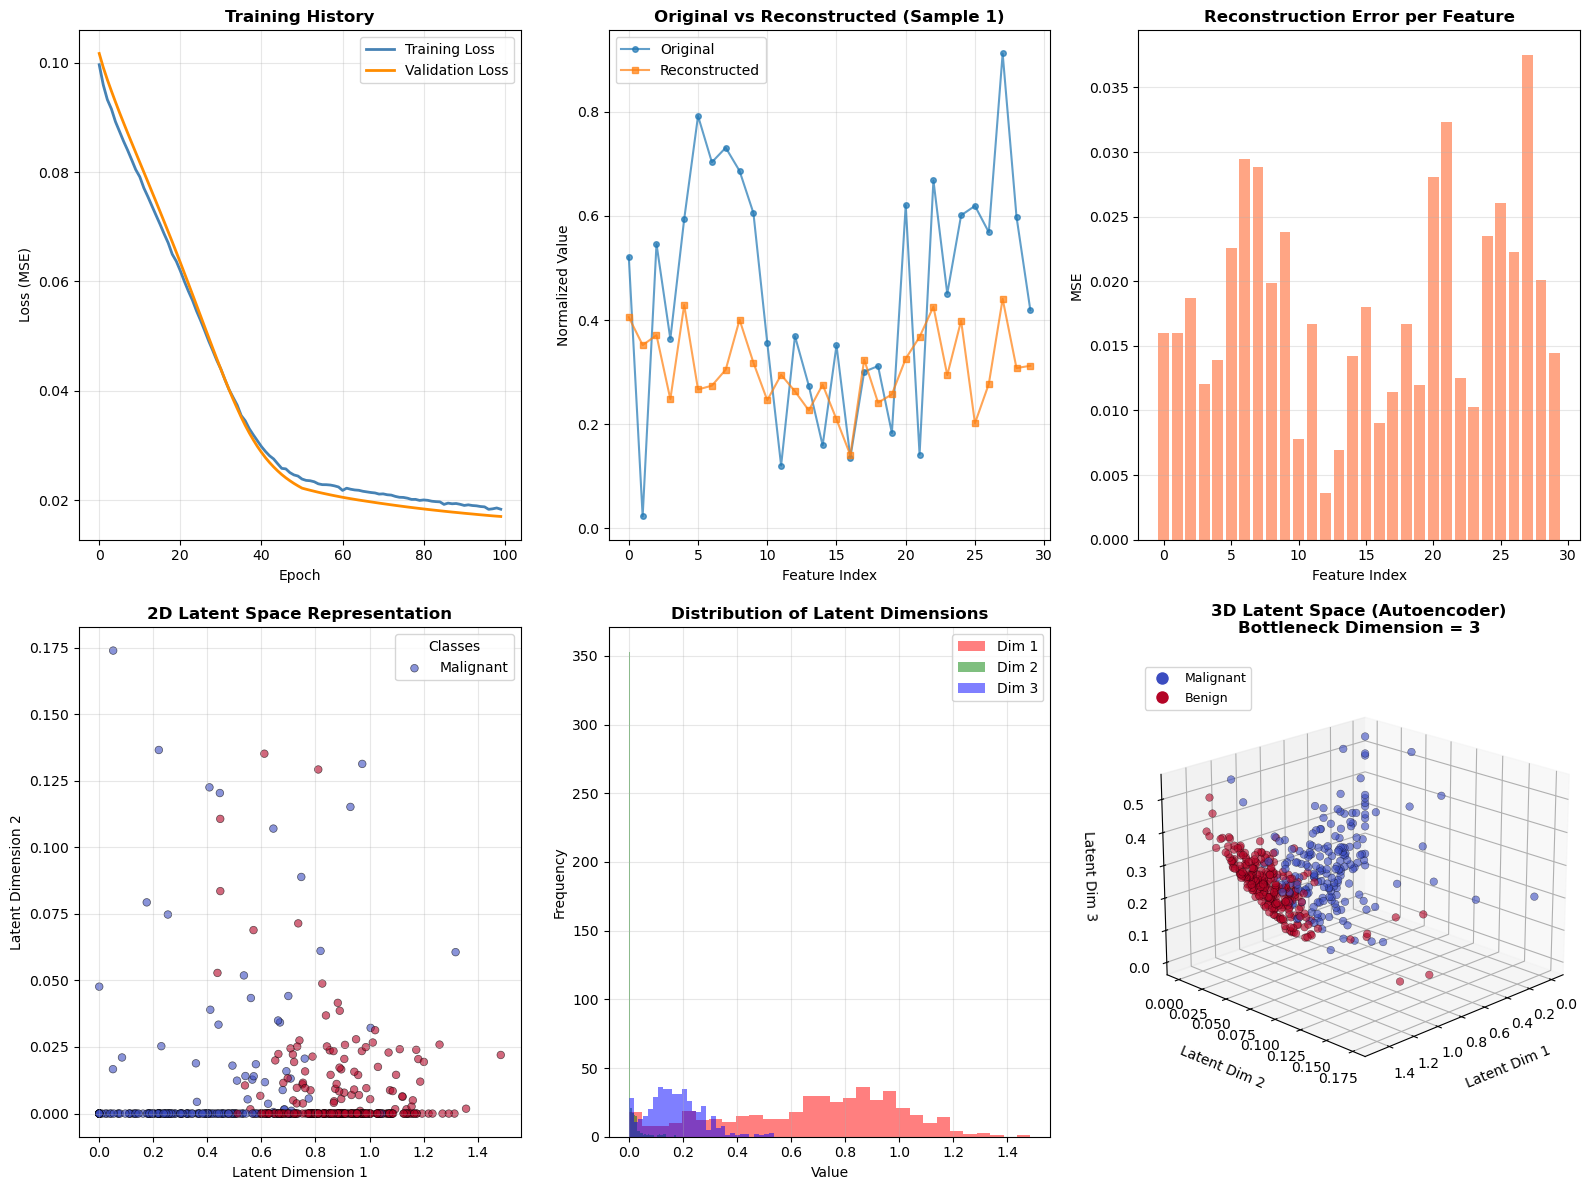


✓ All visualizations generated successfully!

ANALYSIS COMPLETE!


In [32]:

print("\n" + "=" * 70)
print("GENERATING VISUALIZATIONS...")
print("=" * 70)

fig = plt.figure(figsize=(16, 12))

# Plot 1: Training history
ax1 = plt.subplot(2, 3, 1)
ax1.plot(autoencoder.history['loss'], label='Training Loss', linewidth=2, color='steelblue')
ax1.plot(autoencoder.history['val_loss'], label='Validation Loss', linewidth=2, color='darkorange')
ax1.set_xlabel('Epoch', fontsize=10)
ax1.set_ylabel('Loss (MSE)', fontsize=10)
ax1.set_title('Training History', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(alpha=0.3)

# Plot 2: Reconstruction comparison
ax2 = plt.subplot(2, 3, 2)
sample_idx = 0
original = X_train[sample_idx]
reconstructed = autoencoder.reconstruct(X_train[sample_idx:sample_idx+1])[0]
x_axis = np.arange(len(original))
ax2.plot(x_axis, original, 'o-', label='Original', alpha=0.7, markersize=4, linewidth=1.5)
ax2.plot(x_axis, reconstructed, 's-', label='Reconstructed', alpha=0.7, markersize=4, linewidth=1.5)
ax2.set_xlabel('Feature Index', fontsize=10)
ax2.set_ylabel('Normalized Value', fontsize=10)
ax2.set_title('Original vs Reconstructed (Sample 1)', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(alpha=0.3)

# Plot 3: Reconstruction error per feature
ax3 = plt.subplot(2, 3, 3)
X_train_reconstructed = autoencoder.reconstruct(X_train)
feature_errors = np.mean((X_train - X_train_reconstructed) ** 2, axis=0)
ax3.bar(range(len(feature_errors)), feature_errors, color='coral', alpha=0.7)
ax3.set_xlabel('Feature Index', fontsize=10)
ax3.set_ylabel('MSE', fontsize=10)
ax3.set_title('Reconstruction Error per Feature', fontsize=12, fontweight='bold')
ax3.grid(alpha=0.3, axis='y')

# Plot 4: 2D projection of bottleneck (first 2 dimensions)
ax4 = plt.subplot(2, 3, 4)
scatter = ax4.scatter(Z_train[:, 0], Z_train[:, 1], c=y_train, cmap='coolwarm', 
                      alpha=0.6, edgecolors='k', linewidth=0.5, s=30)
ax4.set_xlabel('Latent Dimension 1', fontsize=10)
ax4.set_ylabel('Latent Dimension 2', fontsize=10)
ax4.set_title('2D Latent Space Representation', fontsize=12, fontweight='bold')
ax4.legend(*scatter.legend_elements(), title="Classes", labels=['Malignant', 'Benign'])
ax4.grid(alpha=0.3)

# Plot 5: Distribution of latent dimensions
ax5 = plt.subplot(2, 3, 5)
ax5.hist(Z_train[:, 0], bins=30, alpha=0.5, label='Dim 1', color='red')
ax5.hist(Z_train[:, 1], bins=30, alpha=0.5, label='Dim 2', color='green')
ax5.hist(Z_train[:, 2], bins=30, alpha=0.5, label='Dim 3', color='blue')
ax5.set_xlabel('Value', fontsize=10)
ax5.set_ylabel('Frequency', fontsize=10)
ax5.set_title('Distribution of Latent Dimensions', fontsize=12, fontweight='bold')
ax5.legend()
ax5.grid(alpha=0.3)

# Plot 6: 3D latent space
ax6 = plt.subplot(2, 3, 6, projection='3d')
scatter_3d = ax6.scatter(Z_train[:, 0], Z_train[:, 1], Z_train[:, 2],
                         c=y_train, cmap='coolwarm', alpha=0.6,
                         edgecolors='k', linewidth=0.3, s=30)
ax6.set_xlabel('Latent Dim 1', fontsize=10, labelpad=10)
ax6.set_ylabel('Latent Dim 2', fontsize=10, labelpad=10)
ax6.set_zlabel('Latent Dim 3', fontsize=10, labelpad=10)
ax6.set_title('3D Latent Space (Autoencoder)\nBottleneck Dimension = 3', 
              fontsize=12, fontweight='bold', pad=20)
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', 
                              markerfacecolor='#3b4cc0', markersize=10, label='Malignant'),
                   plt.Line2D([0], [0], marker='o', color='w', 
                              markerfacecolor='#b40426', markersize=10, label='Benign')]
ax6.legend(handles=legend_elements, loc='upper left', fontsize=9)
ax6.grid(True, alpha=0.3)
ax6.view_init(elev=20, azim=45)

plt.tight_layout()
plt.show()

print("\n✓ All visualizations generated successfully!")
print("\n" + "=" * 70)
print("ANALYSIS COMPLETE!")
print("=" * 70)
